# iCPET Data Analysis
## Initial Modeling
### Author: Quentin Auster
### Affiliation: University of Pittsburgh Department of Radiology, Beyond Vision, Pu Labs
### Date: May 9, 2023
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import (
	ColumnTransformer
)
from sklearn.decomposition import (
	PCA
)
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.linear_model import (
	LogisticRegression
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)

from pathlib import Path
import os
import pickle
from tqdm import tqdm

In [285]:
import graphing.graphing as gr
import regression.reg as reg
import eval.eval as eval

In [287]:
eval.avg_feature_importance?

Signature: eval.avg_feature_importance(feat_importances: dict)
Docstring: <no docstring>
File:      c:\users\qaust\onedrive\documents\jp-lab\lab\icpet\src\eval\eval.py
Type:      function


In [243]:
SEED = 123
TEST_SIZE = 0.25


In [244]:
df = pd.read_pickle(Path('../data/df.pickle'))
df.head()

,pe_study_number,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_cvo2,peak_cavo2,peak_paao2,peak_fick_co,peak_vd_vt,peak_cavo2_a_art_hb,normal,dob_mask_cl,study_age_cl,study_date_mask_cl
0,PE1,HB046619,M,3,174,11.931900,0.399756,0.412309,0.326371,0.653708,...,6.82500,13.64394,2.905439,15.604727,0.130000,0.885970,0.0,1977-12-13,49.886379,2027-11-02
1,PE12,HB046622,M,4,264,0.102822,0.041968,0.000000,0.002098,0.405691,...,8.21862,12.46494,19.274715,16.523663,0.205714,0.799035,0.0,1986-05-02,45.412731,2031-09-30
2,PE12,HB046622,M,2,95,1.391170,0.000000,0.000000,0.000000,0.114441,...,8.21862,12.46494,19.274715,16.523663,0.205714,0.799035,0.0,1986-05-02,45.412731,2031-09-30
3,PE14,HB046616,F,4,111,0.825384,0.000000,0.000000,0.000000,0.097104,...,7.41872,8.92180,3.302519,18.254263,0.210000,0.737339,0.0,1997-04-05,31.616701,2028-11-16
4,PE15,HB046618,F,3,315,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.58190,12.21672,23.804380,11.849891,0.260000,0.778135,0.0,2010-08-21,18.699521,2029-05-03


In [291]:
list(df.columns)

['pe_study_number',
 'patient_id',
 'gender_pe',
 'series_id',
 'slice_number',
 'centralartery',
 'apical_rs1',
 'posterior_rs2',
 'anterior_rs3',
 'lateral_rs4',
 'medial_rs5',
 'superior_rs6',
 'medial_basal_rs7',
 'anterior_basal_rs8',
 'lateral_basal_rs9',
 'posterior_basal_rs10',
 'apical_ls1',
 'posterior_ls2',
 'anterior_ls3',
 'superior_ls4',
 'inferior_ls5',
 'superior_ls6',
 'anteromedial_basal_ls7_8',
 'lateral_basal_ls9',
 'posterior_basal_ls10',
 'volume_visceral_fat',
 'density_visceral_fat',
 'mass_visceral_fat',
 'volume_subcutaneous_fat',
 'density_subcutaneous_fat',
 'mass_subcutaneous_fat',
 'volume_intermuscular_fat',
 'density_intermuscular_fat',
 'mass_intermuscular_fat',
 'volume_muscle',
 'density_muscle',
 'mass_muscle',
 'volume_bone',
 'density_bone',
 'mass_bone',
 'emphysema_volume_950hu',
 'lung_volume',
 'extrapulmonary_artery_volume',
 'extrapulmonary_vein_volume',
 'intrapulmonary_artery_volume',
 'intrapulmonary_vein_volume',
 'artery_vein_ratio',
 'b

## Preprocessing

In [245]:
df0 = df.loc[df.pe_obs==0, :]
df0.index = df0.pe_study_number

cols_to_drop = [
	'pe_study_number', 'patient_id', 'gender_pe',
	'series_id', 'slice_number', 'dob_mask_pe',
	'dob_mask_pe', 'study_age_cl', 'study_date_mask_cl'
]

df0 = df0.loc[:, df0.columns.difference(cols_to_drop)].dropna()

df0.head()

,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,ve_vco2_slope,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,weight_kg
pe_study_number,,,,,,,,,,,,,,,,,,,,,
PE12,21.0758,45.0,0.014465,0.069840,0.395899,0.000000,0.002098,0.000000,0.000000,0.041968,...,29.557,75.0,10.7,8.038,1.85461,0.904912,6.00182,4.86750,1.988060,111.50
PE14,22.3061,31.0,0.010895,0.054162,0.238598,0.000000,0.000000,0.000000,0.000000,0.000000,...,32.776,92.0,10.2,7.718,1.68335,0.347496,5.08316,4.88387,0.470233,85.55
PE16,19.0939,34.0,0.018406,0.031353,0.137170,0.823018,0.094136,0.010758,1.180730,0.084722,...,32.649,103.0,10.2,10.301,1.64204,1.223160,5.07111,14.34050,2.639580,132.90
PE17,22.6964,48.0,0.023711,0.061792,0.000000,1.065400,1.616640,0.000000,1.341640,0.459778,...,29.550,89.0,16.2,8.967,1.50886,0.424787,4.84570,2.39795,0.809048,78.18
PE18,28.7042,50.0,0.010430,0.043273,0.672433,0.861896,0.000642,0.429664,0.326262,0.969794,...,29.578,121.0,8.9,7.657,1.35921,0.768928,4.43305,8.71137,0.915833,131.50


In [61]:
# COnvert wide to long
df_long = (
	df0.select_dtypes(include=['float', 'int'])
	.melt(
		var_name='variable',
		value_name='value',
		ignore_index=False
	)
)

df_long.head()

,variable,value
pe_study_number,,
PE12,a_diameter,21.0758
PE14,a_diameter,22.3061
PE16,a_diameter,19.0939
PE17,a_diameter,22.6964
PE18,a_diameter,28.7042


In [64]:
# g = sns.PairGrid(
# 	data=df0,
# 	hue='normal',
# )
# g.map_diag(sns.kdeplot)
# g.map_offdiag(sns.scatter)
# plt.show()

In [246]:
df0.resolved_pe.value_counts()

Unresolved    22
Resolved      12
Name: resolved_pe, dtype: int64

In [247]:
X = df0.loc[:, df0.columns.difference(['resolved_pe'])]
y = df0.loc[:, 'resolved_pe']

le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
y

['Resolved' 'Unresolved']


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size=TEST_SIZE,
	random_state=SEED,
	stratify=y
)

y_test

array([0, 1, 1, 0, 0, 1, 1, 1, 1])

In [185]:
# Define numeric and categorical columns
num_columns = list(X.select_dtypes(include=['float', 'int']).columns)
cat_columns = list(X.select_dtypes(include=['category']).columns)

# define the preprocessing steps for numeric and categorical data
numeric_transformer = Pipeline(
	steps=[
		('StandardScaler', StandardScaler()),
		('QuantileTransformer', QuantileTransformer(
			n_quantiles=20,
			output_distribution='normal'
		)),
	]
)

categorical_transformer = Pipeline(
	steps=[
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	]
)

# define the column transformer to apply the appropriate preprocessing to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
	]
)

In [186]:
# Get column names from OneHotEncoder
# and combine with numerical columns

onehot_columns = list(
	preprocessor.get_params()
	.get('cat__onehot')
	.fit(X_train[cat_columns])
	.get_feature_names_out()
)
print(f"OneHotEncoder columns: \n\n{onehot_columns}\n")

pp_columns = list(num_columns) + list(onehot_columns)
print(f"Length of processed columns: {len(pp_columns)}")

OneHotEncoder columns: 

['approached_ventilatory_ceiling_0.0', 'approached_ventilatory_ceiling_1.0', 'borderline_ph_0', 'borderline_ph_1', 'deconditioning_0.0', 'deconditioning_1.0', 'eph_0.0', 'eph_1.0', 'exercise_hfpef_0.0', 'exercise_hfpef_1.0', 'exercise_ph_resting_hfpef_0.0', 'gender_cl_Female', 'gender_cl_Male', 'inappropriate_o2_extraction_0.0', 'inappropriate_o2_extraction_1.0', 'normal_study_0', 'normal_study_1', 'preload_insufficiency_0.0', 'preload_insufficiency_1.0', 'race_Non-White', 'race_White', 'resting_hfpef_0.0', 'resting_hfpef_1.0', 'resting_pah_0', 'resting_pah_1', 'resting_ph_exercise_hfpef_0.0', 'surpassed_ventilatory_ceiling_0.0', 'surpassed_ventilatory_ceiling_1.0', 'systemic_htn_response_0.0', 'systemic_htn_response_1.0']

Length of processed columns: 117


In [162]:
# Process X_train
X_train_proc = pd.DataFrame(
	preprocessor.fit_transform(X_train),
	columns=pp_columns,
	index=X_train.index
)
X_train_proc.head()

C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,race_White,resting_hfpef_0.0,resting_hfpef_1.0,resting_pah_0,resting_pah_1,resting_ph_exercise_hfpef_0.0,surpassed_ventilatory_ceiling_0.0,surpassed_ventilatory_ceiling_1.0,systemic_htn_response_0.0,systemic_htn_response_1.0
pe_study_number,,,,,,,,,,,,,,,,,,,,,
PE16,-1.731664,-1.150349,1.382994,-1.150349,0.430727,0.967422,0.548522,0.104633,1.382994,0.104633,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
PE6,0.812218,-5.199338,0.812218,-0.318639,1.150349,0.318639,0.430727,0.967422,0.967422,-0.430727,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
PE51,-0.812218,0.318639,-1.731664,-0.674490,-5.199338,0.548522,1.382994,0.812218,1.150349,0.967422,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
PE17,-0.318639,-0.548522,5.199338,1.150349,-5.199338,1.382994,1.731664,-5.199338,1.731664,1.382994,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
PE8,0.674490,0.430727,0.548522,0.812218,0.000000,0.812218,0.812218,-5.199338,0.104633,1.150349,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [163]:
# Process X_test
X_test_proc = pd.DataFrame(
	preprocessor.transform(X_test),
	columns=pp_columns,
	index=X_test.index
)
X_test_proc.head()

,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,race_White,resting_hfpef_0.0,resting_hfpef_1.0,resting_pah_0,resting_pah_1,resting_ph_exercise_hfpef_0.0,surpassed_ventilatory_ceiling_0.0,surpassed_ventilatory_ceiling_1.0,systemic_htn_response_0.0,systemic_htn_response_1.0
pe_study_number,,,,,,,,,,,,,,,,,,,,,
PE9,0.532145,0.610295,-0.350158,-0.706110,-5.199338,-5.199338,-5.199338,-0.345477,-5.199338,-5.199338,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
PE41,0.004422,0.174960,-0.626624,0.006677,-5.199338,-5.199338,-5.199338,1.032750,-5.199338,-5.199338,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
PE45,-1.164843,-0.755415,-1.235718,-0.809505,-5.199338,-5.199338,-5.199338,0.065111,-5.199338,-5.199338,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
PE49,0.768426,0.674490,-0.049607,1.393362,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
PE4,0.575771,0.920823,0.126972,1.435344,1.246422,0.047061,-5.199338,-5.199338,-5.199338,1.325546,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


## Modeling

### PCA

### Logistic Regression

In [176]:
logit = LogisticRegression(max_iter=10_000)

logit.fit(X_train_proc, y_train)

# Print train metrics
print(confusion_matrix(y_train, logit.predict(X_train_proc)))
print(classification_report(y_train, logit.predict(X_train_proc)))

# Print test metrics
print(confusion_matrix(y_test, logit.predict(X_test_proc)))
print(classification_report(y_test, logit.predict(X_test_proc)))

[[ 9  0]
 [ 0 16]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

[[3 0]
 [5 1]]
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       1.00      0.17      0.29         6

    accuracy                           0.44         9
   macro avg       0.69      0.58      0.42         9
weighted avg       0.79      0.44      0.37         9



In [165]:
cv_scores = cross_val_score(
	estimator=logit_model,
	X=X, y=y,
	cv=5,
	scoring='accuracy'
)

print(f"Mean cv score: {np.mean(cv_scores):.3f}")
print(f"Stdev of cv score: {np.std(cv_scores):.3f}")

Mean cv score: 0.652
Stdev of cv score: 0.189


### Ensemble Methods

#### Random Forest

In [178]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train_proc, y_train)

# Print train metrics
print("#"*60)
print(confusion_matrix(y_train, random_forest.predict(X_train_proc)))
print(classification_report(y_train, random_forest.predict(X_train_proc)))

# Print test metrics
print("#"*60)
print(confusion_matrix(y_test, random_forest.predict(X_test_proc)))
print(classification_report(y_test, random_forest.predict(X_test_proc)))

# Compute cross validation scores
cv_acc = cross_val_score(
	estimator=random_forest,
	X=X_train_proc, y=y_train,
	cv=5,
	scoring='accuracy'
)

cv_f1 = cross_val_score(
	estimator=random_forest,
	X=X_train_proc, y=y_train,
	cv=5,
	scoring='f1'
)

print("#"*60)
print(f"{'':<25}{'Score':^}")
print(f"{'':<25}{'-----':^}")
print(f"{'Mean cv accuracy: ':<25}{np.mean(cv_acc):>.3f}")
print(f"{'Stdev of cv accuracy: ':<25}{np.std(cv_acc):.3f}")
print(f"{'Mean cv f1: ':<25}{np.mean(cv_f1):>.3f}")
print(f"{'Stdev of cv f1: ':<25}{np.std(cv_f1):.3f}")


############################################################
[[ 9  0]
 [ 0 16]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

############################################################
[[2 1]
 [2 4]]
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.80      0.67      0.73         6

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

############################################################
                         Score
                         -----
Mean cv accuracy:        0.720
Stdev of cv accuracy:    0.204
Mean 

In [179]:
rf_feat_importance = pd.DataFrame({
	'feature': X_train_proc.columns,
	'importance': random_forest.feature_importances_
})

rf_feat_importance = rf_feat_importance.sort_values(by='importance', ascending=False)
rf_feat_importance.loc[:20, :]

,feature,importance
35,lateral_rs4,0.049498
61,percent_co_achieved,0.047487
5,anterior_ls3,0.034286
75,total_clot_burden,0.033792
15,centralartery,0.031576
52,peak_cavo2_a_art_hb,0.029421
56,peak_paao2,0.027300
74,superior_rs6,0.026856
25,extrapulmonary_vein_volume,0.024970
7,anteromedial_basal_ls7_8,0.024105


### KNN Classifier

### SVM

## Evaluation

In [265]:
seeds = np.arange(100)
train_f1 = np.array([])
test_f1 = np.array([])
feat_importances = list()

for current_seed in tqdm(seeds):
	# print(f"Seed {current_seed}")
	# Split into train and test
	X_train, X_test, y_train, y_test = train_test_split(
		X, y,
		test_size=TEST_SIZE,
		random_state=current_seed,
		stratify=y
	)

	# Get columns
	onehot_columns = list(
		preprocessor.get_params()
		.get('cat__onehot')
		.fit(X_train[cat_columns])
		.get_feature_names_out()
	)
	pp_columns = list(num_columns) + list(onehot_columns)

	# Process X_train
	X_train_proc = pd.DataFrame(
		preprocessor.fit_transform(X_train),
		columns=pp_columns,
		index=X_train.index
	)

	# Process X_test
	X_test_proc = pd.DataFrame(
		preprocessor.transform(X_test),
		columns=pp_columns,
		index=X_test.index
	)

	# Fit random forest
	random_forest = RandomForestClassifier()
	random_forest.fit(X_train_proc, y_train)

	# Compute and store scores
	train_f1 = np.append(train_f1, f1_score(y_train, random_forest.predict(X_train_proc)))
	test_f1 = np.append(test_f1, f1_score(y_test, random_forest.predict(X_test_proc)))

	# Store variable importances
	feat_importances.append(dict(zip(pp_columns, random_forest.feature_importances_)))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


In [288]:
# Get the unique keys from all dictionaries
keys = set().union(*feat_importances)

# Create a structured array to hold the values for each key
dtype = [(key, float) for key in keys]
values_array = np.zeros(len(feat_importances), dtype=dtype)

# Fill the array with values from dictionaries
for i, dictionary in enumerate(feat_importances):
    for key, value in dictionary.items():
        values_array[i][key] = value

# Calculate the average values for each key
averages = np.mean(list(values_array[key] for key in keys), axis=1)
sds = np.std(list(values_array[key] for key in keys), axis=1)

avg_feat_importance_df = (
	pd.DataFrame({
		'feature': list(keys),
		'avg_feature_importance': averages,
		'std_feature_importance': sds,
		'se_feature_importance': sds / np.sqrt(100)
	})
	.sort_values(by='avg_feature_importance', ascending=False)
)

In [289]:
avg_feat_importance_df[:20]

,feature,avg_feature_importance,std_feature_importance,se_feature_importance
112,percent_co_achieved,0.048812,0.018776,0.001878
36,peak_cavo2,0.032298,0.016181,0.001618
8,peak_paao2,0.032265,0.015410,0.001541
103,total_clot_burden,0.031184,0.014783,0.001478
18,study_age_pe,0.027200,0.016572,0.001657
38,age,0.027114,0.018412,0.001841
30,peak_cavo2_a_art_hb,0.027028,0.015239,0.001524
101,peak_cao2,0.025470,0.014972,0.001497
63,peak_fick_co,0.023572,0.016051,0.001605
66,centralartery,0.022451,0.013823,0.001382


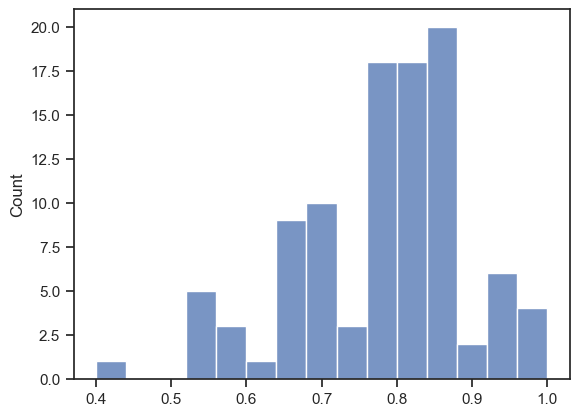

In [296]:
sns.histplot(test_f1, bins=15)
plt.show()

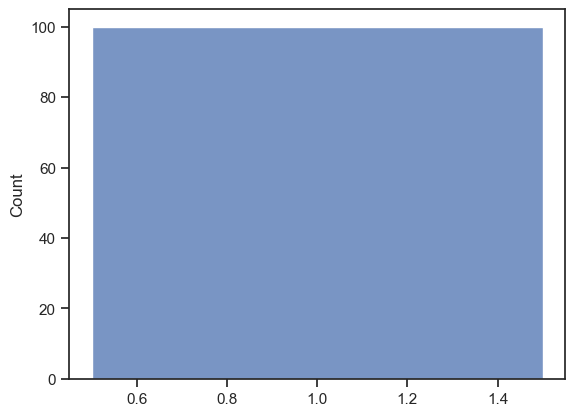

In [295]:
sns.histplot(train_f1)
plt.show()

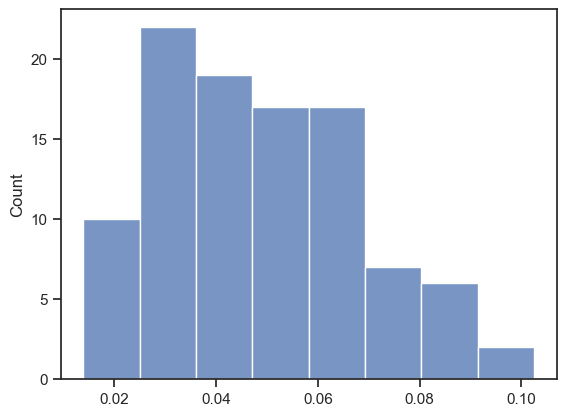

In [278]:
sns.histplot(values_array['percent_co_achieved'])
plt.show()

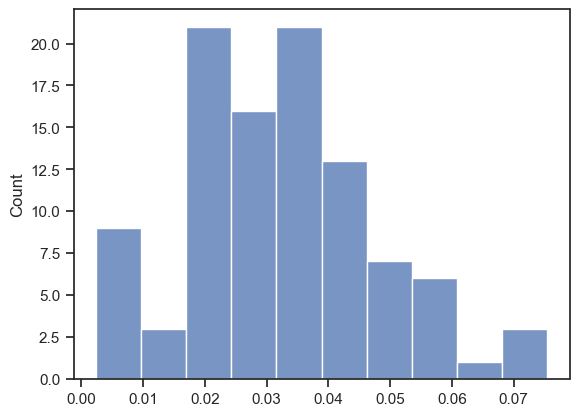

In [280]:
sns.histplot(values_array['peak_paao2'])
plt.show()

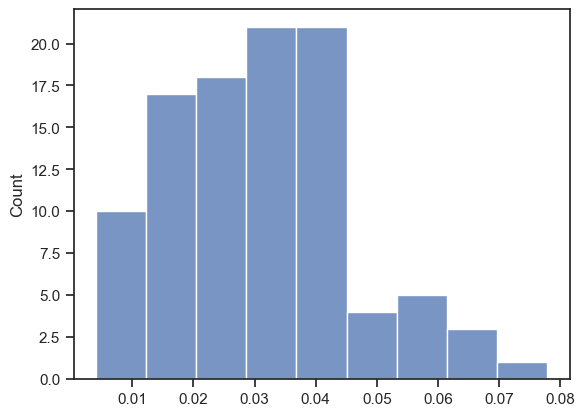

In [281]:
sns.histplot(values_array['total_clot_burden'])
plt.show()